# Eyes State prediction using EEG signals

### Goal
- Test if simple chunked EEG can predict eye state (open/closed).

### Hypotheisis
- Expected for more right-hemisphere acitivity in brain, because of the visual processing.

In [130]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

Data is taken from [UCI EEG Eye Status](https://archive.ics.uci.edu/ml/datasets/EEG+Eye+State) dataset. The duration of the measurement was 117 seconds. The eye state was detected via a camera during the EEG measurement and added later manually to the file after analysing the video frames.

In [131]:
df = pd.read_csv("/content/EEG_Eye_State_Classification.csv")

In [132]:
df.shape

(14980, 15)

**Note:** The samping rate for measurement was ~128hz (14980/117=128.03)

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14980 entries, 0 to 14979
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   AF3           14980 non-null  float64
 1   F7            14980 non-null  float64
 2   F3            14980 non-null  float64
 3   FC5           14980 non-null  float64
 4   T7            14980 non-null  float64
 5   P7            14980 non-null  float64
 6   O1            14980 non-null  float64
 7   O2            14980 non-null  float64
 8   P8            14980 non-null  float64
 9   T8            14980 non-null  float64
 10  FC6           14980 non-null  float64
 11  F4            14980 non-null  float64
 12  F8            14980 non-null  float64
 13  AF4           14980 non-null  float64
 14  eyeDetection  14980 non-null  int64  
dtypes: float64(14), int64(1)
memory usage: 1.7 MB


#### Label/Target - eyeDetection
- Eyes Open - 0
- Eyes Closed - 1

## Sensor(Features) placements on the head
![headset](Images/EEG-brain-sensor.png "Title")

## Line Plots on sensors

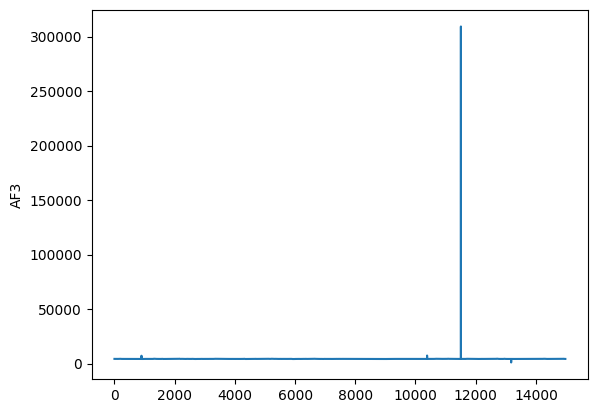

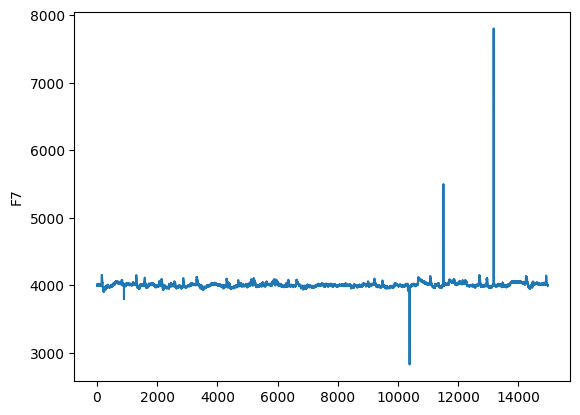

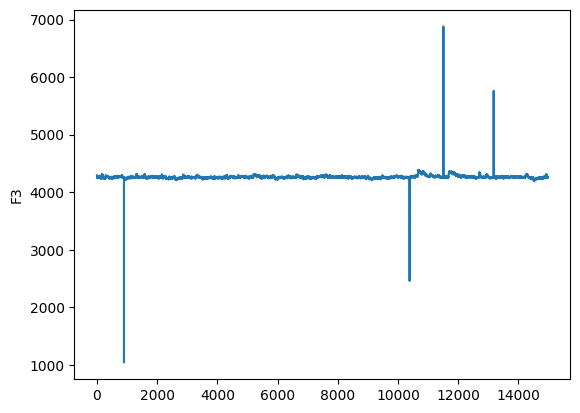

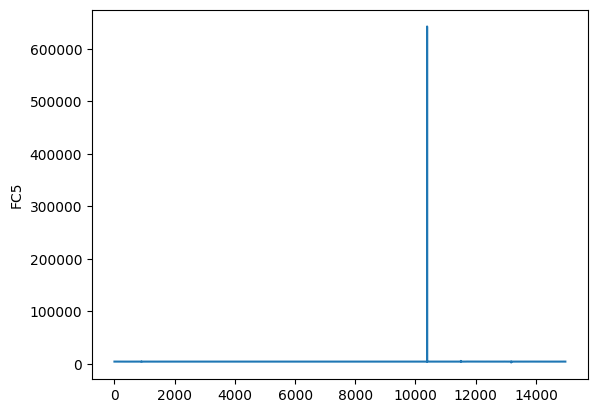

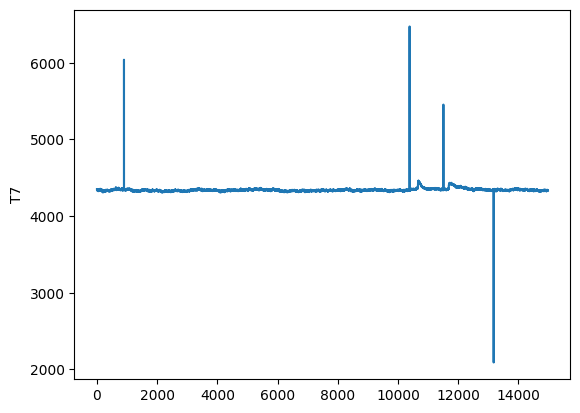

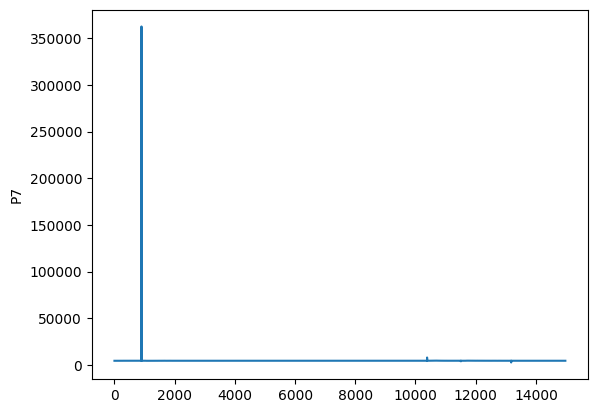

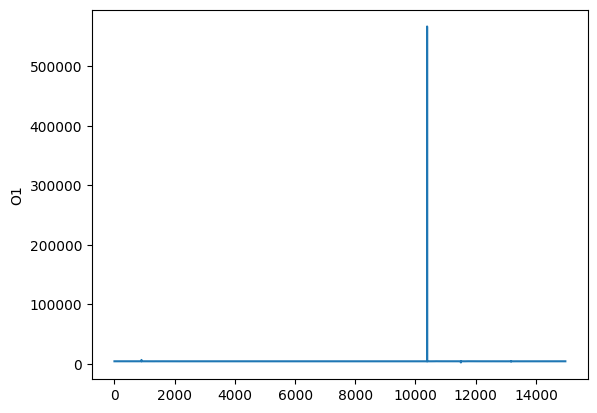

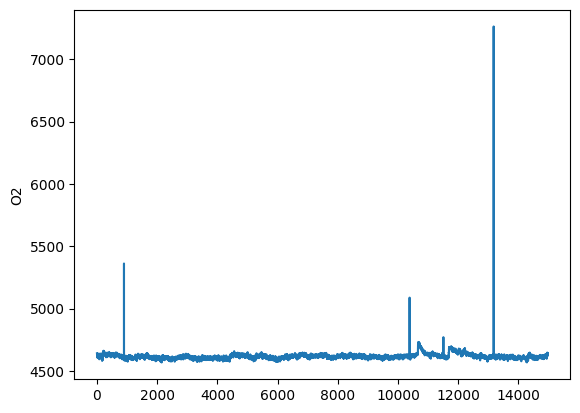

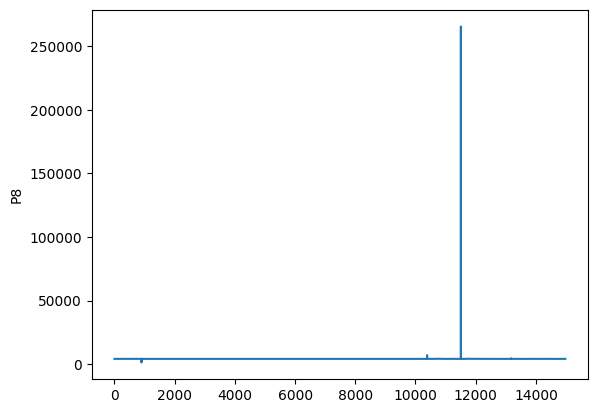

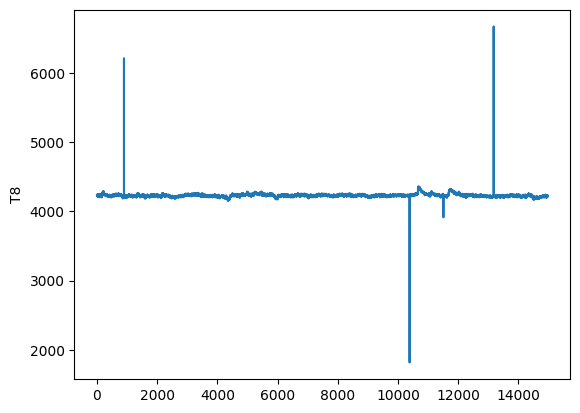

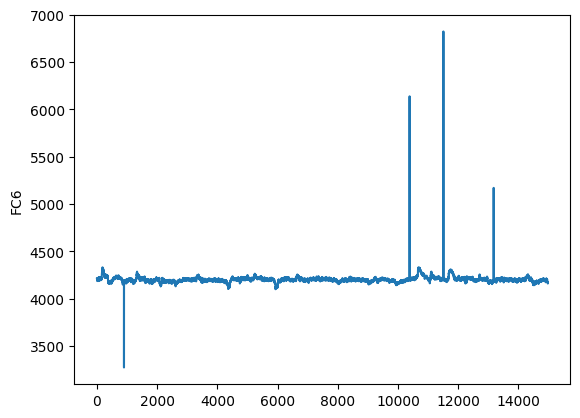

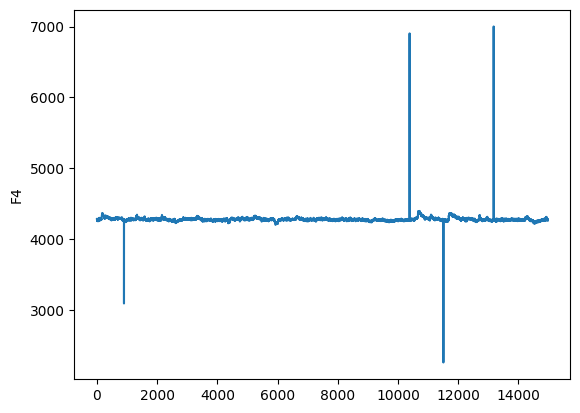

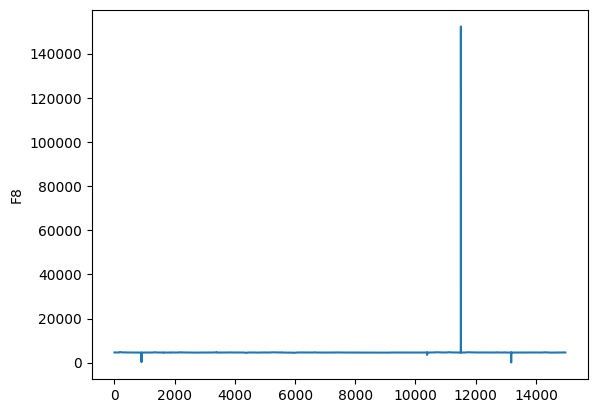

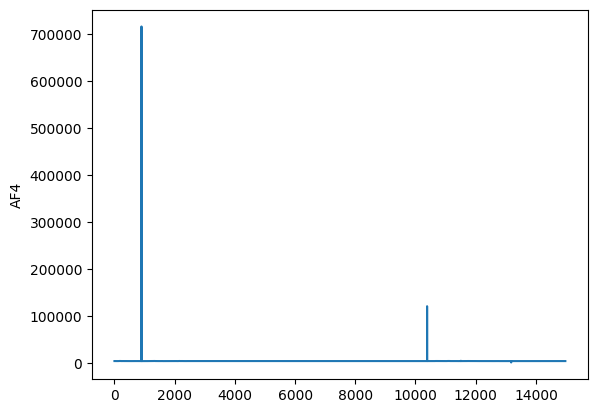

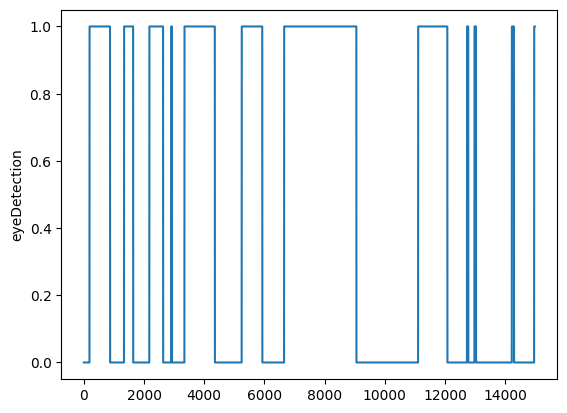

In [134]:
for col in df.columns:
    sns.lineplot(df[col])
    plt.show()

In [135]:
corr = df.corr()

In [136]:
corr['eyeDetection']

,eyeDetection
AF3,0.010458
F7,-0.079994
F3,0.038902
FC5,-0.007531
T7,-0.000369
P7,-0.007845
O1,-0.007223
O2,0.025100
P8,0.009576
T8,0.047218


## Hypothesis Conclusion:
Initially, my hypothesis was that the right hemisphere (associated with visual processing) would show higher activity when the eyes are open, since visual input requires more processing power.

However, my correlation analysis showed the opposite:
- The right frontal (e.g., FC6) and occipital (O2) channels are positively correlated with the eyeDetection label.

- In this dataset, `eyeDetection` = 1 means eyes closed, so higher EEG activity correlates with eyes being closed.


This is actually expected in EEG studies:

    When eyes are closed, alpha waves (8–12 Hz) become more synchronized and stronger, especially over occipital and frontal regions.
    When eyes are open, visual processing causes alpha rhythms to desynchronize — reducing the signal power that scalp sensors pick up.

## Chunking Data for training model

In [137]:
from scipy.signal import welch

In [138]:
def get_alpha(signal, freq=128):
  f, psd = welch(signal, fs=freq)
  alpha_power = psd[(f>=8) & (f<=12)].mean()
  return alpha_power

In [139]:
def get_hjorth_params(signal):
    """Calculate Hjorth parameters: Activity, Mobility, Complexity."""
    activity = np.var(signal)
    if activity == 0:
        return 0, 0, 0
    diff_signal = np.diff(signal)
    mobility = np.std(diff_signal) / np.std(signal)
    diff2_signal = np.diff(diff_signal)
    complexity = (np.std(diff2_signal) / np.std(diff_signal)) / mobility
    return activity, mobility, complexity

In [140]:
def chunk_data(data, stride=4):
    '''
    Note: The stride size of 4 was inteded to work with the window size of 32, and
    I was thinking to use stride size of 8 for 64 size window,
    but since the model is working well with stride 4 I'm leaving it as that.

    With the window size of 32, the model gave accuracy of 93%. Which is probably becuase
    there wasn't much data to calculate and extract meaningful features to predict the target.
    With the 64 window size the accuracy increased to almost perfect accuracy of 99% for hold-out data
    and 98% for on the K-Fold evaluation.
    '''
    new_data = []
    n = data.shape[0]
    cols = ['F7', 'F8', 'AF3', 'O2', 'F3', 'T8', 'F4', 'FC6'] # Choosing columns with high correlation (neg or pos)
    for i in range(0, n-64+1, stride):
        chunk = data.loc[i:i+64,:]
        chunk_agg = {}
        for col in cols:
            activity, mobility, complexity = get_hjorth_params(chunk[col])
            chunk_agg[f'{col}-Mean'] = chunk[col].mean()
            chunk_agg[f'{col}-Var'] = chunk[col].var()
            chunk_agg[f'{col}-alpha'] = get_alpha(chunk[col], freq=64)
            chunk_agg[f'{col}-activity'] = activity
            chunk_agg[f'{col}-mobility'] = mobility
            chunk_agg[f'{col}-complexity'] = complexity

        chunk_agg['eyeState'] = chunk['eyeDetection'].max()
        # chunk_agg = pd.DataFrame(chunk_agg)
        new_data.append(chunk_agg)
    return pd.DataFrame(new_data)

In [141]:
chunked_data = chunk_data(df)

/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 65, using nperseg = 65
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,
/usr/local/lib/python3.11/dist-packages/scipy/signal/_spectral_py.py:790: UserWarning: nperseg = 256 is greater than input length  = 64, using nperseg = 64
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


In [142]:
chunked_data.head()

,F7-Mean,F7-Var,F7-alpha,F7-activity,F7-mobility,F7-complexity,F8-Mean,F8-Var,F8-alpha,F8-activity,...,F4-activity,F4-mobility,F4-complexity,FC6-Mean,FC6-Var,FC6-alpha,FC6-activity,FC6-mobility,FC6-complexity,eyeState
0,4006.193231,55.311932,1.293661,54.460979,0.903397,1.405815,4620.102154,122.101623,1.777356,120.223137,...,73.954240,0.769136,1.540589,4204.386923,92.566590,1.483351,91.142489,0.698941,1.522758,0
1,4006.366923,57.793509,1.396656,56.904378,0.886450,1.414057,4618.958154,119.621522,2.592295,117.781190,...,73.843003,0.783081,1.491312,4204.363231,95.387710,1.884546,93.920206,0.702263,1.488271,0
2,4006.864000,62.884271,1.918647,61.916821,0.851142,1.469574,4619.131538,124.121857,3.677315,122.212290,...,105.541533,0.649373,1.816462,4205.467846,114.281761,2.542563,112.523580,0.643291,1.602960,0
3,4006.359077,64.513443,2.715746,63.520928,0.824156,1.514233,4617.979692,120.619087,4.750569,118.763409,...,105.834859,0.656359,1.713246,4205.018000,115.765435,3.169221,113.984428,0.619166,1.608297,0
4,4006.659077,62.553734,3.541966,61.591368,0.833456,1.491278,4617.632615,128.167901,5.503745,126.196087,...,105.680457,0.621469,1.805541,4204.804923,120.188560,3.505914,118.339505,0.607446,1.647063,0


In [143]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, KFold
import numpy as np

In [144]:
X = chunked_data.copy()
y = X.pop('eyeState')

## Test on holdout

In [145]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.9, random_state=42)

In [146]:
X_train.describe()

,F7-Mean,F7-Var,F7-alpha,F7-activity,F7-mobility,F7-complexity,F8-Mean,F8-Var,F8-alpha,F8-activity,...,F4-alpha,F4-activity,F4-mobility,F4-complexity,FC6-Mean,FC6-Var,FC6-alpha,FC6-activity,FC6-mobility,FC6-complexity
count,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3.357000e+03,3.357000e+03,3.357000e+03,...,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000,3357.000000
mean,4009.590795,1523.833386,40.959811,1500.389617,0.544926,2.762655,4616.023934,1.602861e+06,5.087694e+04,1.578201e+06,...,44.670557,1411.000081,0.645774,1.999879,4202.435923,978.157771,28.948429,963.109176,0.614413,2.174361
std,25.249052,15035.890307,675.007436,14804.568906,0.229427,1.662830,158.628746,2.312391e+07,1.016799e+06,2.276816e+07,...,503.111805,11000.594411,0.183884,0.755187,22.174951,8217.508377,364.664257,8091.085172,0.193842,0.903136
min,3923.747692,19.028522,0.032825,18.735776,0.069600,1.094228,4483.171846,2.534107e+01,9.549035e-02,2.495121e+01,...,0.108473,15.778912,0.148211,1.104482,4125.547077,21.514773,0.059181,21.183777,0.158611,1.111677
25%,3992.867385,48.398120,0.704164,47.653534,0.389045,1.794229,4592.457385,6.035817e+01,9.583475e-01,5.942959e+01,...,0.843102,45.522144,0.544930,1.583112,4192.496615,50.063803,0.798760,49.293591,0.507543,1.648127
50%,4006.232308,83.398779,1.104956,82.115720,0.558667,2.167711,4603.455538,8.840867e+01,1.573572e+00,8.704854e+01,...,1.388675,60.622797,0.651465,1.784913,4201.191385,68.693256,1.289711,67.636437,0.624858,1.864692
75%,4022.422000,229.878292,1.746353,226.341703,0.685630,3.037201,4616.134462,1.683824e+02,2.556663e+00,1.657919e+02,...,2.244320,89.410674,0.740463,2.147389,4209.664923,115.429558,2.025753,113.653719,0.716394,2.346774
max,4102.146462,223337.949000,18349.207667,219901.980554,1.454765,16.485166,6867.554769,3.357316e+08,2.794651e+07,3.305664e+08,...,9423.407878,113470.672592,1.440751,7.385207,4314.556462,105752.431805,8788.111336,104125.471316,1.447326,7.419459


In [147]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [148]:
single_preds = model.predict(X_test)

### Results
#### Classification Report

In [149]:
print(classification_report(y_test, single_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       190
           1       0.99      0.98      0.99       183

    accuracy                           0.99       373
   macro avg       0.99      0.99      0.99       373
weighted avg       0.99      0.99      0.99       373



#### Confusion Matrix

In [150]:
cm = confusion_matrix(y_test, single_preds)
labels = ['Class 0', 'Class 1']
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

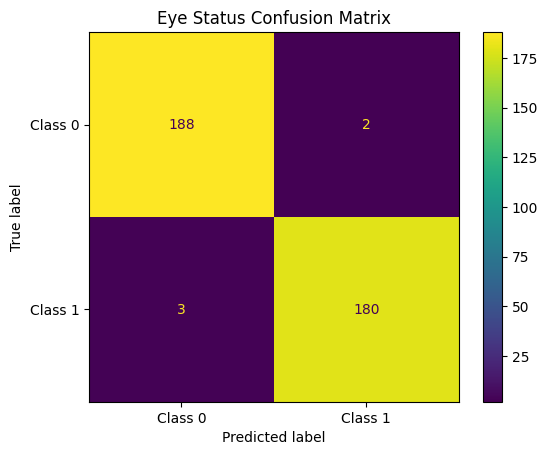

In [151]:
cm_display.plot()
plt.title('Eye Status Confusion Matrix')
plt.show()

In [152]:
def plot_feature_importance(importance,names,model_type):

  #Create arrays from feature importance and feature names
  feature_importance = np.array(importance)
  feature_names = np.array(names)

  #Create a DataFrame using a Dictionary
  data={'feature_names':feature_names,'feature_importance':feature_importance}
  fi_df = pd.DataFrame(data)

  #Sort the DataFrame in order decreasing feature importance
  fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Plot Searborn bar chart
  sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
  #Add chart labels
  plt.title(model_type + 'FEATURE IMPORTANCE')
  plt.xlabel('FEATURE IMPORTANCE')
  plt.ylabel('FEATURE NAMES')

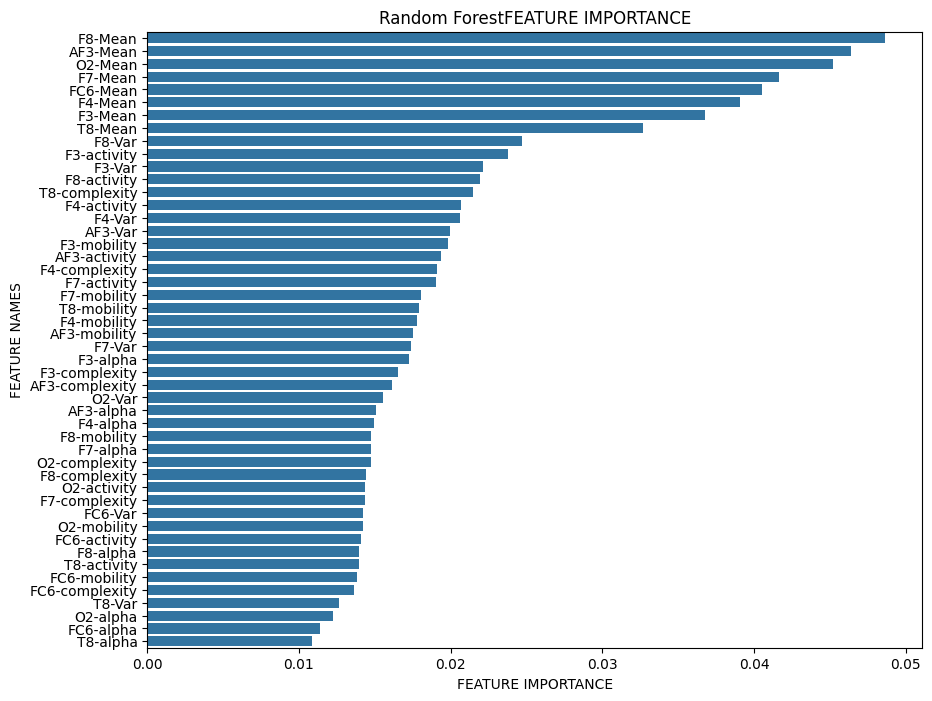

In [153]:
plot_feature_importance(model.feature_importances_, X.columns, 'Random Forest')

## Training K-Fold

In [154]:
def k_train(X, y, k=5):
    model = RandomForestClassifier(random_state=42)
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    preds = np.zeros(len(y))
    for i, (train_idx, test_idx) in enumerate(kf.split(X)):
        print(f'Training {i+1} model')
        X_train = X.iloc[train_idx]
        y_train = y.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]
        model.fit(X_train, y_train)

        pred = model.predict(X_test)
        preds[test_idx] = pred

    return preds

In [155]:
preds = k_train(X, y)

Training 1 model
Training 2 model
Training 3 model
Training 4 model
Training 5 model


### Results
#### Classification Report

In [156]:
print(classification_report(y, preds))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1872
           1       0.98      0.98      0.98      1858

    accuracy                           0.98      3730
   macro avg       0.98      0.98      0.98      3730
weighted avg       0.98      0.98      0.98      3730



#### Confusion Matrix

In [157]:
cm = confusion_matrix(y, preds)
labels = ['Class 0', 'Class 1']
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

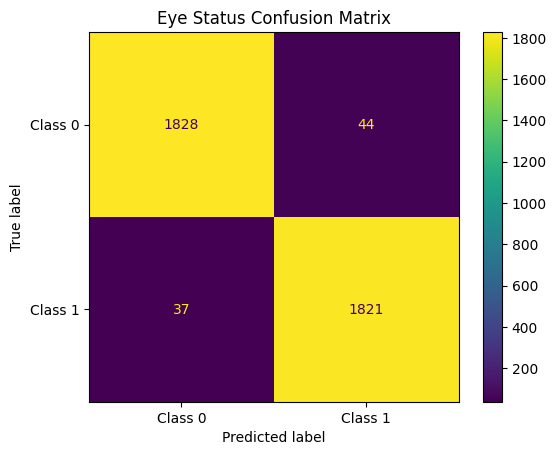

In [158]:
cm_display.plot()
plt.title('Eye Status Confusion Matrix')
plt.show()

## Conclusion

So, the model is correctly picking up on this well-known EEG phenomenon. Despite my initial hypothesis being backwards, the data and classifier make sense in the context of brainwave behavior.